In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
import os
from keras.layers import Input, Embedding, multiply, BatchNormalization
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers
from keras import applications
from keras import layers
from keras import optimizers
from tensorflow.keras.initializers import RandomNormal
import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras.initializers import glorot_normal
import random
from sklearn.model_selection import train_test_split
from keras.utils import generic_utils
from keras.optimizers import Adam

D:\Program Files\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
D:\Program Files\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
D:\Program Files\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be remo

In [2]:
df_raw = pd.read_csv('creditcard.csv')
df_raw['Amount'] = np.log10(df_raw['Amount'].values + 1)
df_raw['Time'] = (df_raw['Time'].values/3600)


target = 'Class'

# Divide the training data into training (80%) and test (20%)
df_train, df_test = train_test_split(df_raw, train_size=0.8, random_state=42, stratify=df_raw[target])

# Reset the index
df_train, df_test = df_train.reset_index(drop=True), df_test.reset_index(drop=True)

x_train_fraud = df_train[df_train['Class'] == 1].drop(target, axis=1)

x_train = df_train.drop(target, axis=1)
y_train = df_train[target]
x_test = df_test.drop(target, axis=1)
y_test = df_test[target]


# %% --------------------------------------- Set Seeds -----------------------------------------------------------------
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
weight_init = glorot_normal(seed=SEED)

# %% ---------------------------------- Hyperparameters ----------------------------------------------------------------
latent_dim = 32
data_dim = len(x_train.columns)
n_classes = len(np.unique(y_train))
optimizer = Adam(lr=0.0001)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [105]:
# Build Encoder
def encoder():
    data = Input(shape=(data_dim,))
    
    x = Dense(256, kernel_initializer=weight_init)(data)
    x = LeakyReLU(0.2)(x)

    x = Dense(128, kernel_initializer=weight_init)(x)
    x = LeakyReLU(0.2)(x)

    x = Dense(64, kernel_initializer=weight_init)(x)
    x = LeakyReLU(0.2)(x)

    encodered = Dense(latent_dim)(x)

    model = Model(inputs=data, outputs=encodered)
    return model

def decoder():
    noise = Input(shape=(latent_dim,))

    x = Dense(64, kernel_initializer=weight_init)(noise)
    x = LeakyReLU(0.2)(x)

    x = Dense(128, kernel_initializer=weight_init)(x)
    x = LeakyReLU(0.2)(x)

    x = Dense(256, kernel_initializer=weight_init)(x)
    x = LeakyReLU(0.2)(x)

    generated = Dense(data_dim, kernel_initializer=weight_init)(x)

    generator = Model(inputs=noise, outputs=generated)
    return generator

def generator(decoder):

    noise = Input(shape=(latent_dim,))

    generated_feature = decoder(noise)
    model = Model(inputs=noise, outputs=generated_feature)

    return model

def discriminator(encoder, decoder):

    data = Input(shape=(data_dim,))
    
    x = encoder(data)
    out = decoder(x)

    model = Model(inputs=data, outputs=out)
    model.compile(optimizer=optimizer, loss=l1Loss)
    return model

def l1Loss(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def train_G(generator, discriminator):
    # Freeze the discriminator when training generator
    discriminator.trainable = False

    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(optimizer=optimizer, loss=l1Loss)

    return model

In [165]:
class BEGAN:
    def __init__(self, g_model, d_model, kLambda = 0.000001, k=0.06):
        self.z = latent_dim
        self.optimizer = optimizer
        
        self.generator = g_model
        self.discriminator = d_model
        self.kLambda = kLambda
        self.k = k
        
        self.train_G = train_G(self.generator, self.discriminator)
        self.loss_D, self.loss_G = [], []
        
    def train(self, data, batch_size, steps_per_epoch=100, gamma=0.5):

        for epoch in range(steps_per_epoch):
            # Select a random batch of transactions data
            idx = np.random.randint(0, data.shape[0], batch_size)
            real_data = data[idx]

            # generate a batch of new data
            noise_D = np.random.normal(0, 1, size=(batch_size, latent_dim))
            fake_data_D = self.generator.predict(noise_D)

            # Train D
            d_loss_real = self.discriminator.train_on_batch(real_data, real_data)
            
            weights = -self.k * np.ones(batch_size)
            d_loss_fake = self.discriminator.train_on_batch(fake_data_D, fake_data_D, weights)
            d_loss = d_loss_real + d_loss_fake
            self.loss_D.append(d_loss)

            # Train G
            noise_G = np.random.normal(0, 1, size=(batch_size, latent_dim))
            fake_data_G = self.generator.predict(noise_G)
            loss_g = self.train_G.train_on_batch(noise_G, fake_data_G)
            self.loss_G.append(loss_g)

            #Update k
            self.k = self.k + self.kLambda * (gamma * d_loss_real - loss_g)
            self.k = min(max(self.k, 1e-05), 1)

            #Report Results
            m_global = d_loss + np.abs(gamma*d_loss_real - loss_g)
                
            if (epoch + 1) * 10 % steps_per_epoch == 0:
                print('Steps (%d / %d): [loss_D: %f] [Loss_G: %f] [M_global: %f]' %
                  (epoch+1, steps_per_epoch, 100*self.loss_D[-1], self.loss_G[-1], m_global))

        return

In [149]:
import matplotlib.patches as mpatches
def boxplot_compare(df1, df2,title):
  fig, ax = plt.subplots(figsize=(16,10))
  bp1 = df1.boxplot(color='green', showfliers=False)
  bp2 = df2.boxplot(color='hotpink', showfliers=False)

  patch1 = mpatches.Patch(color='green', label='Original')
  patch2 = mpatches.Patch(color='hotpink', label='BEGAN')
  plt.legend(handles=[patch1, patch2], prop={'size': 16})
  ax.set_title(title)
  plt.xticks(rotation=90)
  plt.show()

In [150]:
def gen_data(generator, n_data):
    noise = np.random.normal(0, 1, size=(n_data, latent_dim))
    gen = generator.predict(noise)
    x_train_gen = np.concatenate((x_train, gen))
    y_gen = np.array(gen.shape[0] * [1])
    y_train_gen = np.concatenate((y_train, y_gen))
    return gen, x_train_gen, y_train_gen

In [174]:
D = discriminator(encoder(), decoder())
G = generator(decoder())
trainer = BEGAN(g_model=G, d_model=D)

EPOCHS = 20
X_train = x_train_fraud.to_numpy()
for epoch in range(EPOCHS):
    print('EPOCH # ', epoch + 1, '-' * 50)
    trainer.train(X_train, batch_size=64, steps_per_epoch=100)
#     if (epoch+1) % 1 == 0:
#         trainer.generator.save('gan_pre_generator.h5')

EPOCH #  1 --------------------------------------------------


D:\Program Files\anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
D:\Program Files\anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
D:\Program Files\anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Steps (10 / 100): [loss_D: 258.182621] [Loss_G: 0.323131] [M_global: 3.559384]
Steps (20 / 100): [loss_D: 178.518414] [Loss_G: 0.536941] [M_global: 2.157022]
Steps (30 / 100): [loss_D: 136.715806] [Loss_G: 0.664502] [M_global: 1.406800]
Steps (40 / 100): [loss_D: 108.681452] [Loss_G: 0.776678] [M_global: 1.296686]
Steps (50 / 100): [loss_D: 100.062120] [Loss_G: 1.134572] [M_global: 1.600144]
Steps (60 / 100): [loss_D: 115.734398] [Loss_G: 1.226584] [M_global: 1.771050]
Steps (70 / 100): [loss_D: 81.058800] [Loss_G: 0.811663] [M_global: 1.192036]
Steps (80 / 100): [loss_D: 78.831214] [Loss_G: 0.561605] [M_global: 0.938429]
Steps (90 / 100): [loss_D: 74.862576] [Loss_G: 0.508255] [M_global: 0.868088]
Steps (100 / 100): [loss_D: 66.013592] [Loss_G: 0.470927] [M_global: 0.787031]
EPOCH #  2 --------------------------------------------------
Steps (10 / 100): [loss_D: 61.332864] [Loss_G: 0.462651] [M_global: 0.755350]
Steps (20 / 100): [loss_D: 62.697154] [Loss_G: 0.472021] [M_global: 0.770

Steps (90 / 100): [loss_D: 30.578968] [Loss_G: 0.982029] [M_global: 1.102883]
Steps (100 / 100): [loss_D: 31.726423] [Loss_G: 1.021839] [M_global: 1.150622]
EPOCH #  11 --------------------------------------------------
Steps (10 / 100): [loss_D: 34.046403] [Loss_G: 0.999441] [M_global: 1.141670]
Steps (20 / 100): [loss_D: 34.809467] [Loss_G: 0.923167] [M_global: 1.070271]
Steps (30 / 100): [loss_D: 32.214037] [Loss_G: 0.861862] [M_global: 0.997802]
Steps (40 / 100): [loss_D: 37.186813] [Loss_G: 0.883166] [M_global: 1.044136]
Steps (50 / 100): [loss_D: 38.793612] [Loss_G: 0.875320] [M_global: 1.043612]
Steps (60 / 100): [loss_D: 31.591678] [Loss_G: 0.801828] [M_global: 0.935803]
Steps (70 / 100): [loss_D: 35.258472] [Loss_G: 0.793220] [M_global: 0.947578]
Steps (80 / 100): [loss_D: 38.050091] [Loss_G: 0.727470] [M_global: 0.895528]
Steps (90 / 100): [loss_D: 32.622015] [Loss_G: 0.732002] [M_global: 0.873656]
Steps (100 / 100): [loss_D: 32.118493] [Loss_G: 0.706403] [M_global: 0.845527]

Steps (60 / 100): [loss_D: 28.448325] [Loss_G: 4.266831] [M_global: 4.289491]
Steps (70 / 100): [loss_D: 17.527455] [Loss_G: 4.801738] [M_global: 4.757676]
Steps (80 / 100): [loss_D: 16.920543] [Loss_G: 5.242315] [M_global: 5.196826]
Steps (90 / 100): [loss_D: 15.595847] [Loss_G: 4.730126] [M_global: 4.674268]
Steps (100 / 100): [loss_D: 18.740515] [Loss_G: 4.700145] [M_global: 4.672210]


In [175]:
# generate 1000 more fraud
gen_1000, x_train_gen_1000, y_train_gen_1000 = gen_data(trainer.generator, 1000)

In [176]:
df_gen_1000 = pd.DataFrame(data=gen_1000, index=None, columns=x_train.columns)
df_gen_1000.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,46.818562,2.122376,4.966058,-5.213339,0.230031,1.549477,-1.205598,-4.679256,3.683882,-3.399981,...,-0.736072,2.648195,-2.084086,1.267950,-1.667399,-0.008234,2.165588,1.044918,2.460699,2.584993
std,16.844614,0.793716,1.795726,2.013069,0.336180,0.617610,0.648573,1.684656,1.354170,1.261832,...,0.395104,1.120094,0.799279,0.530096,0.718772,0.245835,0.811548,0.519788,0.889305,0.987165
min,6.206626,-0.135594,0.725467,-12.805466,-0.718602,0.044913,-3.373381,-11.403675,0.733083,-8.746175,...,-2.284837,0.232635,-5.270448,0.035107,-5.004840,-0.888700,0.282974,-0.119818,0.419965,0.394607
25%,34.534291,1.576544,3.665828,-6.441269,-0.012195,1.106354,-1.633956,-5.735670,2.701262,-4.203778,...,-1.001285,1.838617,-2.595543,0.893740,-2.132948,-0.173711,1.578925,0.656086,1.817258,1.856227
50%,45.042454,2.030622,4.769767,-5.067262,0.197246,1.495785,-1.151297,-4.515211,3.543905,-3.291607,...,-0.700095,2.557671,-1.995108,1.234791,-1.596146,-0.014987,2.081345,0.986331,2.392403,2.478579
75%,57.417752,2.600114,6.078724,-3.812953,0.432756,1.922821,-0.726993,-3.417418,4.557916,-2.506143,...,-0.463523,3.320289,-1.484709,1.602264,-1.136390,0.154408,2.635030,1.380292,2.989487,3.195832
max,114.041725,5.255000,13.005849,-0.357272,1.477548,4.227959,0.213480,-0.566312,9.033512,-0.541003,...,0.253075,7.158760,-0.139466,3.526330,-0.025261,0.899345,5.603903,3.110516,6.069761,6.512512


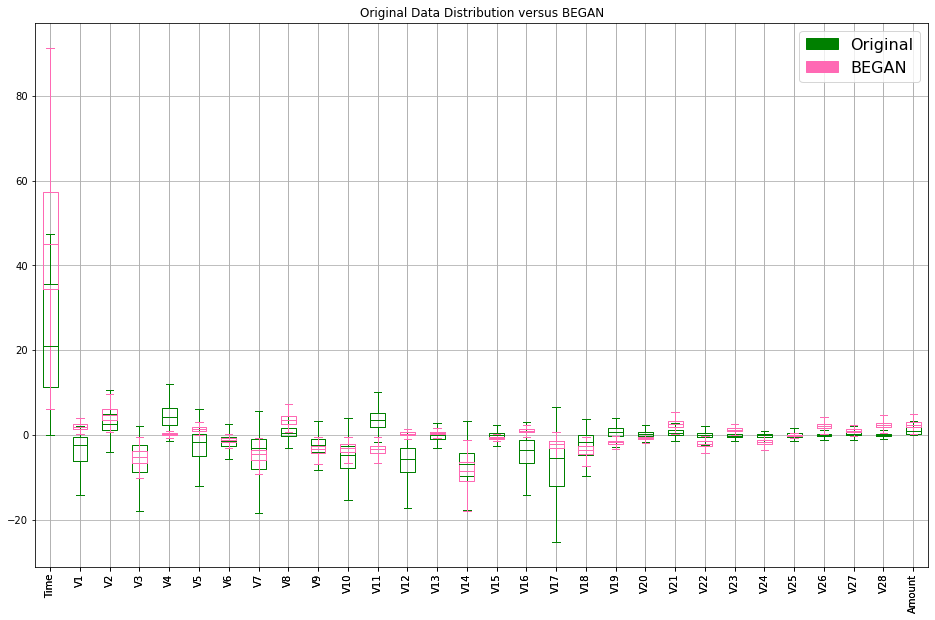

In [177]:
df = pd.read_csv('creditcard.csv')
df['Time'] = (df['Time'].values / 3600)
df['Amount'] = np.log10(df['Amount'].values + 1)

feature = df.loc[:, df.columns != 'Class']
true = df.loc[df['Class'] == 0]
fraud = df.loc[df['Class'] == 1]
true = true.loc[:, df.columns != 'Class']
fraud = fraud.loc[:, df.columns != 'Class']

boxplot_compare(fraud, df_gen_1000, 'Original Data Distribution versus BEGAN')

In [178]:
ros = RandomOverSampler()
x, y = ros.fit_sample(x_train_gen_1000, y_train_gen_1000)

D:\Program Files\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [179]:
def XGBC_model_predit(x, y):   
    x, y = ros.fit_sample(x, y)
    clf_xgb_os = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0.2, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.02, max_delta_step=0,
              max_depth=10, min_child_weight=2,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=800, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='gpu_hist', validate_parameters=1)
    
    clf_xgb_os.fit(x, y)  
    y_pred_gen_os = clf_xgb_os.predict(x_test.to_numpy())
    return y_pred_gen_os

In [180]:
def check_performance(y_test, y_pred):
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred))
    print('Recall: ', recall_score(y_test, y_pred))
    print('F1 score: ', f1_score(y_test, y_pred))
    print('ROC AUC score: ',  roc_auc_score(y_test, y_pred))

In [181]:
# plot confusion matrix
import scikitplot as skplt
def plot_cm(y_test, y_pred, title):
    skplt.metrics.plot_confusion_matrix(y_test, y_pred,figsize=(8,8))
    plt.title('Confusion Matrix ' + title)
    plt.show()

In [182]:
y_pred_gen_1000 = XGBC_model_predit(x_train_gen_1000, y_train_gen_1000)
check_performance(y_test, y_pred_gen_1000)

D:\Program Files\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Accuracy:  0.9996137776061234
Precision:  0.9222222222222223
Recall:  0.8469387755102041
F1 score:  0.8829787234042554
ROC AUC score:  0.9234078373893171


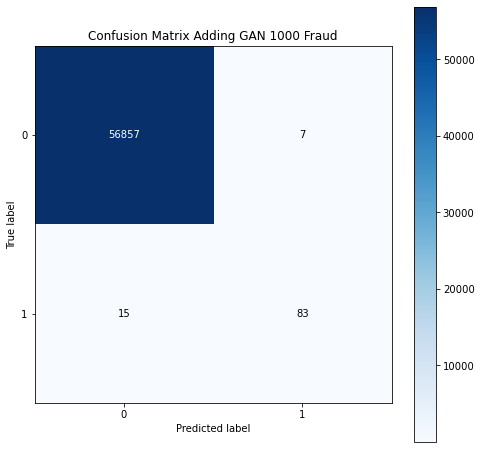

In [183]:
plot_cm(y_test, y_pred_gen_1000, 'Adding GAN 1000 Fraud')